In [134]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
import matplotlib.cm as mcm
import numpy as np
from scipy.signal import savgol_filter
from scipy.stats import gaussian_kde
import geopandas as gpd

from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction, skipped_timeseries_formatting
import seaborn as sns
import networkx as nx

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure X: Network analysis of SARS-CoV-2 similarity in North America.
We use the PhyloSor metric to measure the genomic similarity between all suitably sequenced locations in North America, and determine that the country experience smallworldness at the begining and during periods of high COVID-19 incidence.


We first load in the results from the PhyloSor analysis. These are the output of the `monterey` pipeline. We include comparisons between all locations for months which they sequenced more than 30 genomes. Additionally, some of the network analyses we do require edge length to be specified as a distance, rather than a similarity metric which PhyloSor is. We calculate PhyloSor distance as the reciprical of the PhyloSor similarity.

In [109]:
def correct_names( entry ):
    return_value = entry.replace( "_", ", " )
    if return_value in ["British Columbia", "Ontario", "Alberta", "Québec", "Saskatchewan", "Manitoba", "Nova Scotia"]:
        return_value += ", CAN"
    elif return_value in ["Baja California", "Yucatán"]:
        return_value += ", MEX"
    return return_value

min_sequences = 30

res = pd.read_csv( "../data/phylosor_results_all.csv", parse_dates=["date"] )
res = res.loc[(res["countA"]>=min_sequences)&(res["countB"]>=min_sequences)]
res = res.loc[res["siteA"].str.endswith( ("_USA", "_CAN", "_MEX", "_CA") )&res["siteB"].str.endswith( ("_USA", "_CAN", "_MEX", "_CA") )]
res["siteB"] = res["siteB"].apply( correct_names )
res["siteA"] = res["siteA"].apply( correct_names )
res = res.drop( columns=["num", "kind"] )
res["reciprical_value"] = 1 / res["value"]
res.head()

,blA,blB,blBoth,date,siteA,countA,siteB,countB,value,value_turn,reciprical_value
0,342.0,1371.0,84.0,2020-03-01,"Texas, USA",299,"New York, USA",1951,0.098074,0.245614,10.196429
1,654.0,1496.0,67.0,2020-04-01,"Texas, USA",591,"New York, USA",1110,0.062326,0.102446,16.044776
2,753.0,496.0,24.0,2020-05-01,"Texas, USA",535,"New York, USA",260,0.038431,0.048387,26.020833
3,4081.0,212.0,45.0,2020-06-01,"Texas, USA",3510,"New York, USA",61,0.020964,0.212264,47.700000
4,10563.0,464.0,130.0,2020-07-01,"Texas, USA",6370,"New York, USA",144,0.023578,0.280172,42.411538


We briefly look at the distribution of PhyloSor similarity over time, in case we want to do percentile-based edge pruning

count    61617.000000
mean         0.135598
std          0.076338
min          0.003012
2.5%         0.030362
50%          0.119671
97.5%        0.320415
max          0.633776
Name: value, dtype: float64


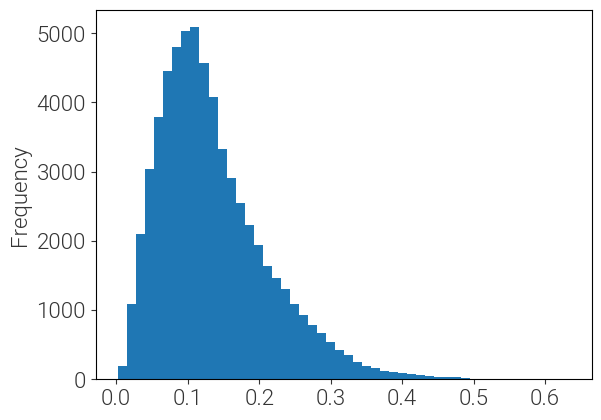

In [110]:
res["value"].plot( kind="hist", bins=50 )
print( res["value"].describe( percentiles=[0.025,0.5,0.975]) )

We next calculated the graph efficiency of the PhyloSor network to estimate smallworldness. Briefly, the global efficiency of a graph measures how optimally information can flow in a network, or in this case how efficiently a virus can be transmitted across it. Efficiency of a graph is the average of the efficiency between each pair of nodes in a graph. Efficiency being the reciprical of the smallest sum of distances connecting a pair of nodes. Again, we're using the reciprical of PhyloSor similarity as our distance metric. This measure can vary from 0, indicating that viral similarity isn't dispersed across a graph, to 1, indicating that viral similarity is high across all locations.


We calculate this metric for each month of the pandemic by bootstrapping nodes in the graph 100 times. As a result this cell takes a few minutes to run, so we save the results to file.

In [10]:
def weighted_global_efficiency( graph, weight ):
    """ Returns the global efficiency of the graph using distance as indicated by weight.
    Parameters
    ----------
    graph : networkx.Graph
    weight : str
        edge weight will be accessed via the edge attribute with this key.

    Returns
    -------
    float
        The average global efficiency of the graph.
    """
    n = len(graph)
    denom = n * (n - 1)
    if denom != 0:
        lengths = nx.all_pairs_dijkstra_path_length(graph, weight=weight)
        g_eff = 0
        for source, targets in lengths:
            for target, distance in targets.items():
                if (distance > 0) & (target != source):
                    g_eff += 1 / distance
        g_eff /= denom
    else:
        g_eff = 0

    return g_eff

results = {
    "date" : [],
    "efficiency" : [],
    "lower" : [],
    "upper" : []
}

bootstraps = 100

for date, df in res.groupby( "date" ):
    boot_results = []
    date_graph = nx.from_pandas_edgelist( df, source="siteA", target="siteB", edge_attr="reciprical_value" )
    for _ in range( bootstraps ):
        sampled_nodes = np.random.choice( date_graph.nodes, size=len( date_graph.nodes ), replace=True )
        boot_graph = date_graph.subgraph( sampled_nodes )
        boot_results.append( weighted_global_efficiency(boot_graph, "reciprical_value" ) )

    limits = np.quantile( boot_results, q=[0.025,0.5,0.975] )
    results["date"].append( date )
    results["lower"].append(limits[0])
    results["efficiency"].append( limits[1])
    results["upper"].append( limits[2] )

results = pd.DataFrame( results )
results.to_csv( "../data/phylosor_network_efficiency.csv", index=False )

,date,efficiency,lower,upper
0,2020-03-01,0.177862,0.160997,0.196043
1,2020-04-01,0.083783,0.074914,0.091786
2,2020-05-01,0.066782,0.060523,0.075324
3,2020-06-01,0.079909,0.071617,0.089952
4,2020-07-01,0.096759,0.088046,0.104792
5,2020-08-01,0.090094,0.082427,0.101161
6,2020-09-01,0.094064,0.086719,0.104108
7,2020-10-01,0.088835,0.080733,0.098023
8,2020-11-01,0.093075,0.086777,0.100109
9,2020-12-01,0.104700,0.098032,0.112370


Here we load the cached results from file.

In [4]:
results = pd.read_csv( "../data/phylosor_network_efficiency.csv", parse_dates=["date"] )
results.head()

,date,efficiency,lower,upper
0,2020-03-01,0.177862,0.160997,0.196043
1,2020-04-01,0.083783,0.074914,0.091786
2,2020-05-01,0.066782,0.060523,0.075324
3,2020-06-01,0.079909,0.071617,0.089952
4,2020-07-01,0.096759,0.088046,0.104792


Next we plot the global efficiency over time compared to the COVID-19 incidence in San Diego.

/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/analyses/utils.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_8403/3585436623.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


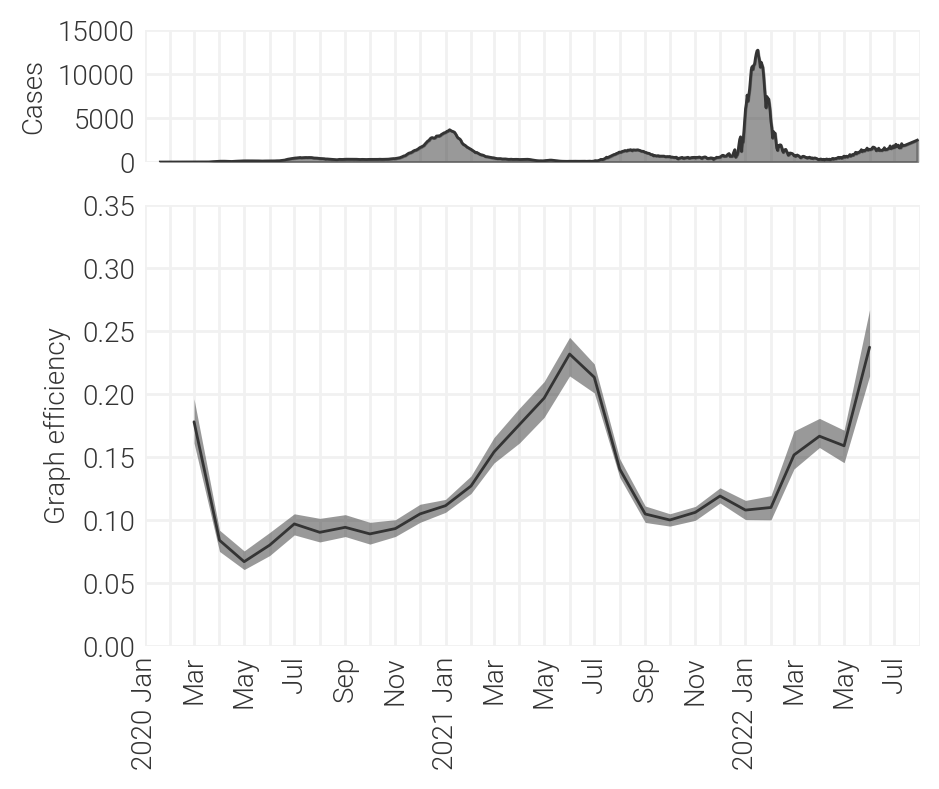

In [29]:
cases = pd.read_csv( "estimated-importation-risk/back-calculated-infections.csv", parse_dates=["date"], usecols=["date", "location", "cases"] )
cases = cases.loc[cases["location"]=="San Diego County"]
cases["cases_smooth"] = savgol_filter( cases["cases"], window_length=31, polyorder=2 )

fig, ax = plt.subplots( dpi=200, figsize=(5,4), nrows=2, sharex=True, gridspec_kw={"height_ratios" : (0.3, 1), "hspace" : 0.15} )
ax[0].plot( cases["date"], cases["cases_smooth"], color=COLOR, zorder=9, linewidth=1 )
ax[0].fill_between( cases["date"], cases["cases_smooth"], color=COLOR, alpha=0.5, zorder=8 )
basic_formatting( ax[0], spines=[], which="both", ylabel="Cases", xsize=10, ysize=10, ylims=(0,15000) )
ax[0].label_outer()
ax[0].set_yticks( [0, 5000, 10000, 15000] )
#ax[0].set_yscale( "log" )

ax[1].fill_between( x="date", y1="lower", y2="upper", data=results, color=COLOR, alpha=0.5, linewidth=0, zorder=10 )
ax[1].plot( "date", "efficiency", data=results, color=COLOR, solid_capstyle="round", linewidth=1, zorder=11 )

basic_formatting( ax[1], spines=[], which="both", ylabel="Graph efficiency", xsize=10, ysize=10, xlims=( pd.to_datetime( "2020-01-01" ), pd.to_datetime("2022-08-01") ), ylims=(0, 0.35) )

skipped_timeseries_formatting( ax[1] )
# Format axes ticks
ax[1].tick_params( axis="x", rotation=90 )
ax[1].legend().remove()

plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_phylosor-network-efficiency.pdf" )
plt.show()

Next we looked at Gini index to quantify heterogeneity in the contribution of each node to global efficiency. In this instance, the nodal efficiency of each node is its average PhyloSor similarity to all other location. So the Gini index reflexs how much hetergeneity there is in each locations average similarity. In this case, a low value indicates all locations have identical similar to each other, while a high value means relative few locations have a high similarity to other locations.

In [30]:
# Calculate nodal efficiency for each location
def nodal_efficiency( graph, weight ):
    """ Returns the nodal efficiency of each node in the graph using the distance indicated by weight.
    Parameters
    ----------
    graph : networkx.Graph
    weight : str
        edge weight will be accessed via the edge attribute with this key.

    Returns
    -------
    list( float )
        Nodal efficiency of each node in graph.
    """
    ne = list()
    lengths = nx.all_pairs_dijkstra_path_length(graph, weight=weight)
    for source, targets in lengths:
        carrier = 0
        for target, distance in targets.items():
            if (distance > 0) & (target != source):
                carrier += 1 / distance
        ne.append( carrier / ( len( graph ) - 1 ) )
    return ne


def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

ne_results = {
    "date" : [],
    "gini_index" : [],
    "lower" : [],
    "upper" : [],
}

bootstraps = 100

for date, df in res.groupby( "date" ):
    boot_results = []
    date_graph = nx.from_pandas_edgelist( df, source="siteA", target="siteB", edge_attr="reciprical_value" )
    for _ in range( bootstraps ):
        sampled_nodes = np.random.choice( date_graph.nodes, size=len( date_graph.nodes ), replace=True )
        boot_graph = date_graph.subgraph( sampled_nodes )
        nes = nodal_efficiency( boot_graph, weight="reciprical_value" )
        boot_results.append( gini( nes ) )

    limits = np.quantile( boot_results, q=[0.025,0.5,0.975] )
    ne_results["date"].append( date )
    ne_results["lower"].append(limits[0])
    ne_results["gini_index"].append( limits[1])
    ne_results["upper"].append( limits[2] )

ne_results = pd.DataFrame( ne_results )
ne_results

,date,gini_index,lower,upper
0,2020-03-01,0.110447,0.081511,0.135618
1,2020-04-01,0.117304,0.092241,0.139482
2,2020-05-01,0.128971,0.110512,0.150516
3,2020-06-01,0.123946,0.092120,0.150590
4,2020-07-01,0.114752,0.089976,0.135389
5,2020-08-01,0.118719,0.093674,0.139214
6,2020-09-01,0.104223,0.082240,0.121734
7,2020-10-01,0.104791,0.083123,0.116724
8,2020-11-01,0.100266,0.080198,0.120707
9,2020-12-01,0.101363,0.083452,0.118052


Here we plot how the Gini index of nodal efficiency changes over time.

/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/analyses/utils.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )


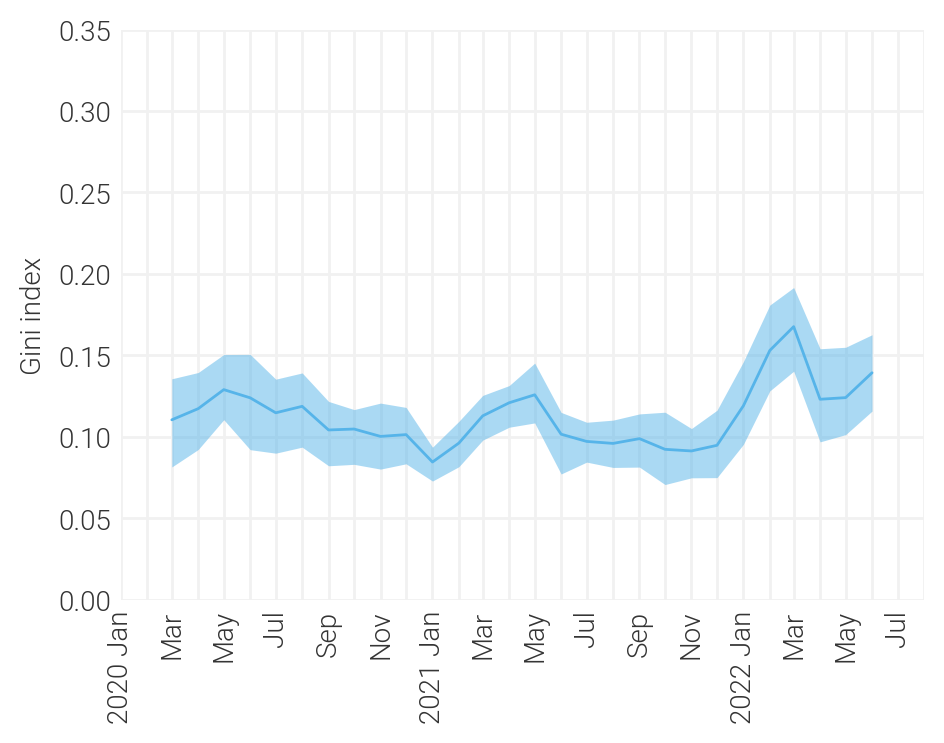

In [33]:
fig, ax = plt.subplots( dpi=200, figsize=(5,4) )
ax.fill_between( x="date", y1="lower", y2="upper", data=ne_results, color="#56B4E9", alpha=0.5, linewidth=0, zorder=10 )
ax.plot( "date", "gini_index", data=ne_results, color="#56B4E9", solid_capstyle="round", linewidth=1, zorder=11 )

basic_formatting( ax, spines=[], which="both", ylabel="Gini index", xsize=10, ysize=10, xlims=( pd.to_datetime( "2020-01-01" ), pd.to_datetime("2022-08-01") ), ylims=(0, 0.35) )

skipped_timeseries_formatting( ax )
# Format axes ticks
ax.tick_params( axis="x", rotation=90 )
ax.legend().remove()

plt.tight_layout()
plt.show()

To identify what are the most important locations in the phylosor network, we rely on the concept of centrality. Simply put, for each pair of locations, we calculate the most similar path between them. The centrality of each location is the proportion of paths that pass through them. Because we're using viral similarity as the distance in our network, intuitively, the centrality of a locations refers to the amount of virus that moves through each location.


In [111]:
central = list()
for date, df in res.groupby( "date" ):
    date_graph = nx.from_pandas_edgelist( df, source="siteA", target="siteB", edge_attr="value" )
    temp = nx.current_flow_betweenness_centrality( date_graph, weight="value" )
    temp = pd.DataFrame( temp, index=[date] ).T
    central.append( temp )

central = pd.concat( central, axis=1 )

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
<class 'networkx.utils

<AxesSubplot:>

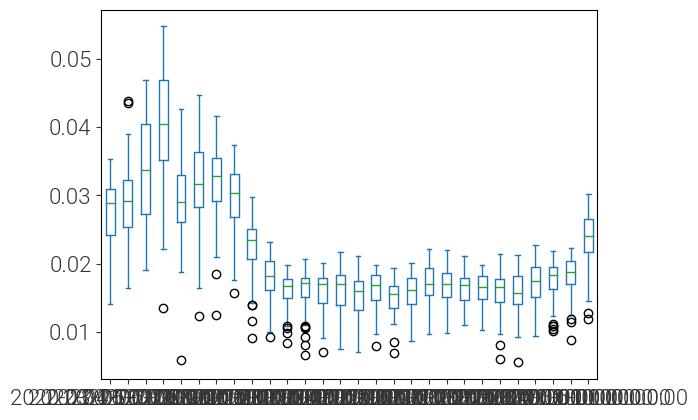

In [112]:
central.plot( kind="box" )

In [113]:
central.median( axis=1 ).sort_values(ascending=False )

San Francisco, CA        0.020911
Alameda, CA              0.020662
Orange, CA               0.020293
Santa Clara, CA          0.020259
Contra Costa, CA         0.019937
                           ...   
New York, USA            0.012940
Saskatchewan, CAN        0.012817
Alberta, CAN             0.012653
Texas, USA               0.011597
British Columbia, CAN    0.011586
Length: 80, dtype: float64

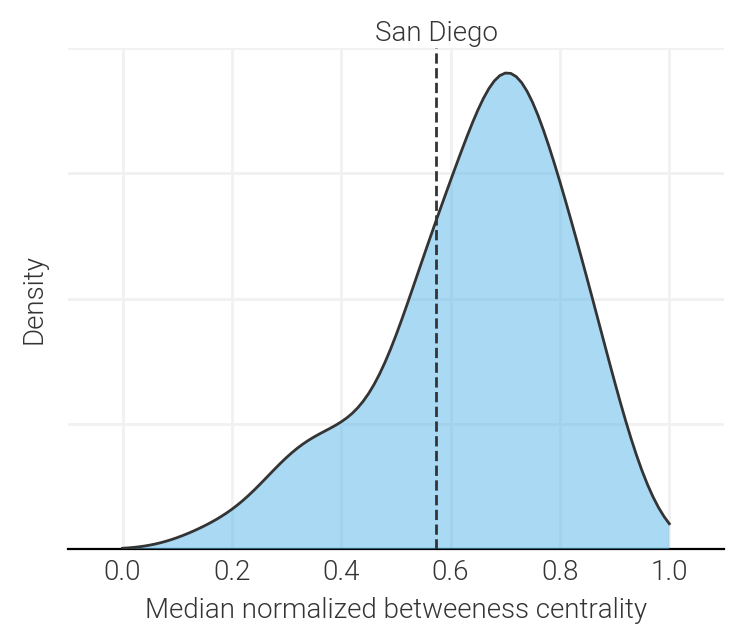

In [141]:
fig, ax = plt.subplots( dpi=200, figsize=(4,3.5) )

data = central.apply( lambda x: (x - x.min()) / (x.max() - x.min())).median( axis=1 )
data.name = "centrality"
x_grid = np.linspace( 0, 1, 101 )
kde = gaussian_kde( data )
y_grid = kde.evaluate( x_grid )
y_grid = y_grid / y_grid.max() * 0.95
ax.plot([x for x in x_grid],y_grid,color=COLOR,lw=1,zorder=101)
ax.fill_between(x_grid,[y for y in y_grid], facecolor="#56B4E9", edgecolor='none', alpha=0.5, zorder=100)

sd_pos = data["San Diego, CA"]
ax.axvline( sd_pos, color=COLOR, linestyle="dashed", linewidth=1, zorder=102 )
ax.annotate( "San Diego", (sd_pos, ax.get_ylim()[1]), (0,3), textcoords="offset points", ha="center", size=10, color=COLOR )
ax.set_ylim( 0 )
basic_formatting( ax, which="both", ylabel="Density", xlabel="Median normalized betweeness centrality", xlims=(-0.1, 1.1), ylims=(0,1), xsize=10, ysize=10 )
ax.tick_params( axis="x", rotation=0 )
ax.set_yticks( [0,0.25,0.5,0.75,1] )
ax.set_yticklabels( [] )
plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_phylosor-network-centrality-normalized.pdf" )
plt.show()

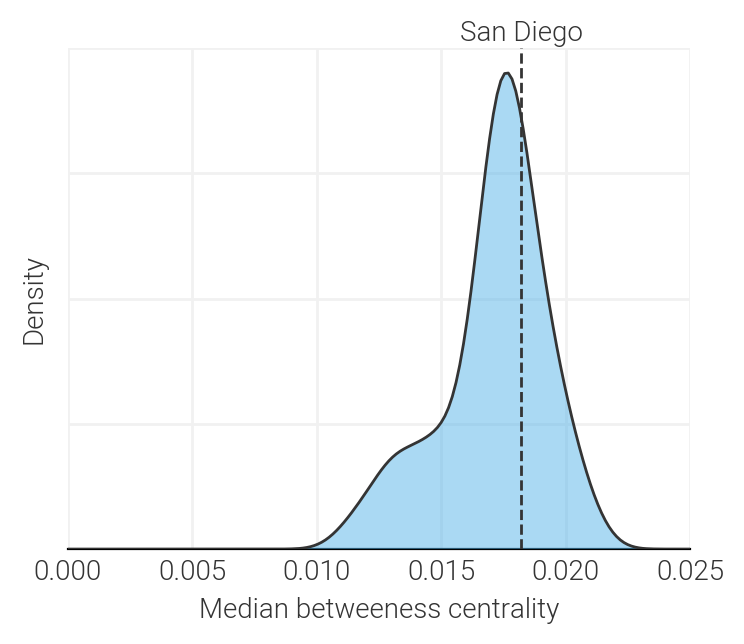

In [124]:
fig, ax = plt.subplots( dpi=200, figsize=(4,3.5) )

data = central.median( axis=1 )
x_grid = np.linspace( 0, 0.03, 201 )
kde = gaussian_kde( data )
y_grid = kde.evaluate( x_grid )
y_grid = y_grid / y_grid.max() * 0.95
ax.plot([x for x in x_grid],y_grid,color=COLOR,lw=1,zorder=101)
ax.fill_between(x_grid,[y for y in y_grid], facecolor="#56B4E9", edgecolor='none', alpha=0.5, zorder=100)

sd_pos = data["San Diego, CA"]
ax.axvline( sd_pos, color=COLOR, linestyle="dashed", linewidth=1, zorder=102 )
ax.annotate( "San Diego", (sd_pos, ax.get_ylim()[1]), (0,3), textcoords="offset points", ha="center", size=10, color=COLOR )
ax.set_ylim( 0 )
basic_formatting( ax, which="both", ylabel="Density", xlabel="Median betweeness centrality", xlims=(0, 0.025), ylims=(0,1), xsize=10, ysize=10 )
ax.tick_params( axis="x", rotation=0 )
ax.set_yticks( [0,0.25,0.5,0.75,1])
ax.set_yticklabels( [] )
plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_phylosor-network-centrality.pdf" )
plt.show()

In [118]:
states = gpd.read_file( "/Users/natem/Data/raw_data/shapefiles/NA_states/bound_p.shx" )
states = states.loc[states["COUNTRY"].isin(["USA", "MEX", "CAN"])]
states = states.drop( columns=["OBJECTID", "BOUND_P_", "UIDENT", "STATEABB", "Shape_Area", "Shape_Leng"])
states = states.dissolve( "NAME" ).reset_index()
states["NAME"] = states["NAME"].replace( {"British Columbia / Colombie-Britannique": "British Columbia", "Quebec / Québec" : "Québec", "Nova Scotia / Nouvelle-Écosse" : "Nova Scotia"} )
states["NAME"] = states["NAME"] + ", " + states["COUNTRY"]
states = states.loc[~states["NAME"].isin( ["California, USA","water/agua/d'eau, CAN"] )]

ca = gpd.read_file( "/Users/natem/Data/raw_data/shapefiles/USA_county/gadm36_USA_2.shx" )
ca = ca.loc[ca["NAME_1"]=="California",["NAME_2", "geometry"]]
ca["COUNTRY"] = "USA"
ca.columns = ["NAME", "geometry", "COUNTRY"]
ca = ca.dissolve( "NAME").reset_index()
ca["NAME"] = ca["NAME"] + ", CA"

states = pd.concat( [states,ca], ignore_index=True )

# Haversine great circle distance
#states["longitude"] = states.centroid.x * (np.pi / 180)
#states["latitude"] = states.centroid.y * (np.pi / 180)
#states["distance"] = haversine_distances( states[["latitude","longitude"]] )[states.loc[states["NAME"]=="San Diego, CA"].index].T
states = states.to_crs( "EPSG:2163" )
states["geometry"] = states.simplify(1000)

states

,NAME,geometry,COUNTRY
0,"Aguascalientes, MEX","POLYGON ((-198707.008 -2544337.499, -200108.56...",MEX
1,"Alabama, USA","MULTIPOLYGON (((1149723.362 -1556706.795, 1139...",USA
2,"Alaska, USA","MULTIPOLYGON (((-4332957.499 3296537.514, -432...",USA
3,"Alberta, CAN","POLYGON ((-558692.930 1700003.618, -644121.433...",CAN
4,"Arizona, USA","POLYGON ((-803220.067 -845640.068, -863633.459...",USA
...,...,...,...
152,"Tulare, CA","POLYGON ((-1614470.731 -849845.881, -1748643.8...",USA
153,"Tuolumne, CA","POLYGON ((-1681571.031 -606535.609, -1686263.2...",USA
154,"Ventura, CA","MULTIPOLYGON (((-1804907.952 -1092281.957, -17...",USA
155,"Yolo, CA","POLYGON ((-1912797.619 -421462.105, -1913904.6...",USA


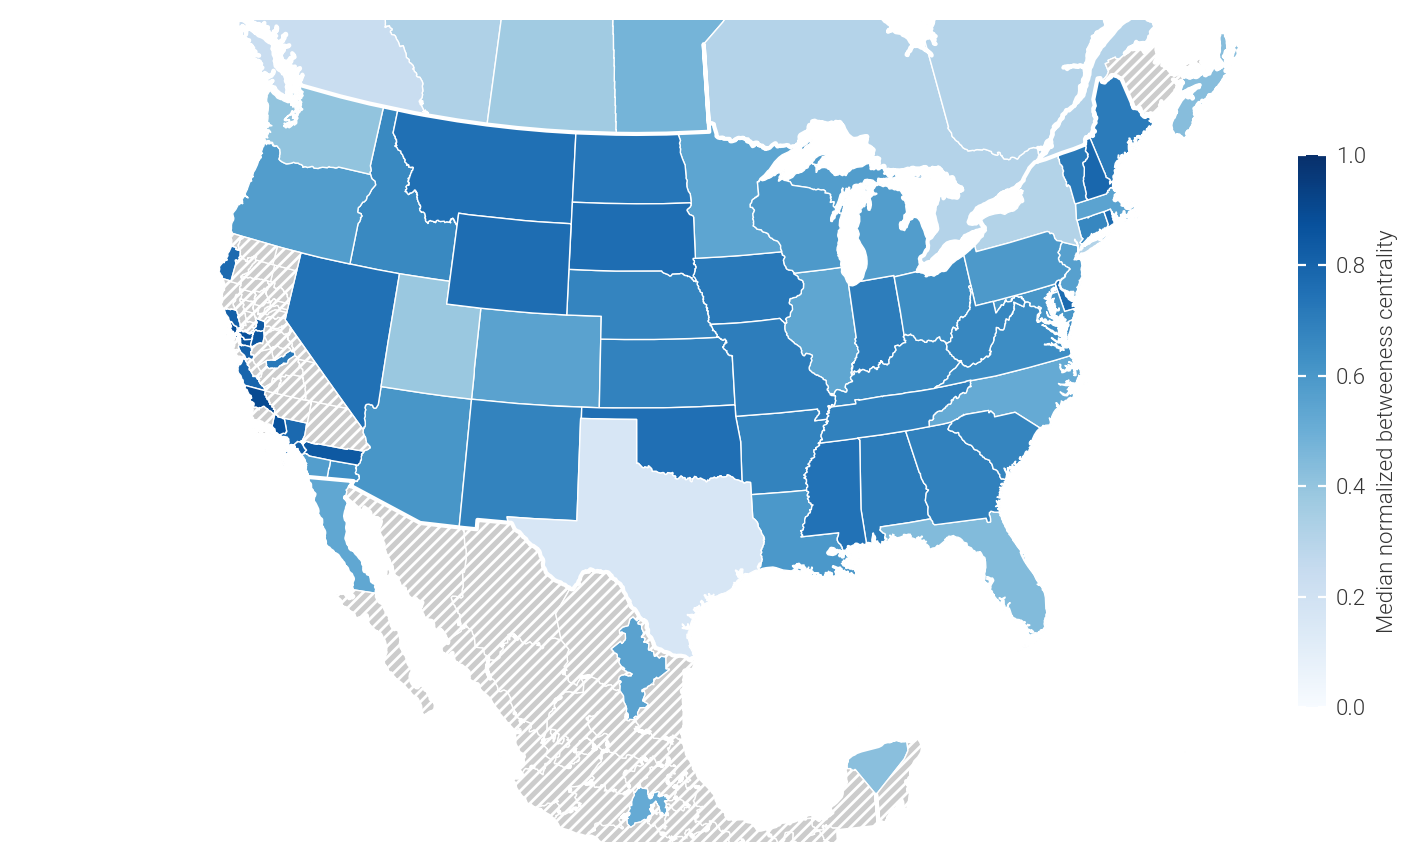

In [147]:
data = central.apply( lambda x: (x - x.min()) / (x.max() - x.min())).median( axis=1 )
data.name = "centrality"
plot_states = states.merge( data, left_on="NAME", right_index=True, how="outer" )

fig, ax = plt.subplots( dpi=200, figsize=(8,6) )
plot_states.plot( column="centrality", edgecolor="w", linewidth=0.5, ax=ax, cmap="Blues",
              vmin=0, vmax=1,
              missing_kwds={
                 "color": "#cccccc",
                 "hatch": "//////",
                 "label": "Missing values",
             } )

plot_states.loc[plot_states["COUNTRY"]=="CAN"].dissolve().boundary.plot( linewidth=1.5, edgecolor="w", ax=ax )
plot_states.loc[plot_states["COUNTRY"]=="MEX"].dissolve().boundary.plot( linewidth=1.5, edgecolor="w", ax=ax )

cbar = fig.colorbar( mcm.ScalarMappable( cmap="Blues", norm=Normalize(vmin=0, vmax=1 ) ),
                   shrink=0.5, pad=0.03 )
cbar.outline.set_visible( False )
cbar.set_label( "Median normalized betweeness centrality", fontsize=8 )
cbar.ax.tick_params( labelsize=8, size=3, left=True, right=True, color="w", direction="in", which="both" )

ax.set_xlim( (-3e6, 3e6) )
ax.set_ylim( (-3e6, 1e6) )
[ax.spines[j].set_visible(False) for j in ax.spines]
ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_phylosor-network-centrality-map.pdf" )
plt.show()